## MAKING COLLAGE

Collage saved as 'final_collage.jpg'


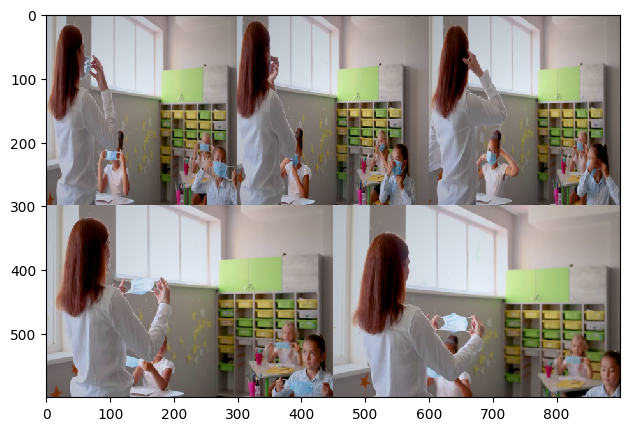

In [15]:
import numpy as np
import os
from skimage import io, color, transform, filters, draw
from scipy.ndimage import sobel

# Function calculating the color variance
def calculate_color_variance(image):
    hsv = color.rgb2hsv(image)
    v = hsv[:, :, 2]
    return np.var(v)

# Function to calculate the edge strength
def calculate_edge_strength(image):
    gray = color.rgb2gray(image)
    edges = sobel(gray)
    return np.sum(edges)

# Function to calculate the color histogram variance
def calculate_histogram_variance(image):
    hist, _ = np.histogram(image.ravel(), bins=8, range=[0, 256])
    hist = hist / hist.sum()
    return np.var(hist)

# Function to apply gradual softening to the edges of an image
def apply_gradual_softening(image, radius=0.2):
    
    h, w, _ = image.shape
    center_x, center_y = w // 2, h // 2
    yy, xx = np.mgrid[:h, :w]   # Creating a coordinate grid
    distance = np.sqrt((yy - center_y) ** 2 + (xx - center_x) ** 2) # Calculating the distance from each pixel to the center
    normalized_distance = distance / max(center_x, center_y) # Normalizing the distance to the range [0, 1]
    mask = 1.0 - normalized_distance * radius  # Creating a linear gradient mask based on the normalized distance
    mask = np.clip(mask, 0, 1) # Clipping the mask to ensure values are in the range [0, 1]
    softened_image = image * mask[:, :, np.newaxis] # Applying the mask to the image

    return softened_image

# Function to sort the frames by color and edge.
def sort_frames(frames):
    frames.sort(key=lambda frame: (calculate_color_variance(frame), calculate_edge_strength(frame), calculate_histogram_variance(frame)))

# Function to create smooth transitions between frames
def create_smooth_transition(frame1, frame2, alpha):
    blended_frame = (1 - alpha) * frame1 + alpha * frame2
    return blended_frame

# Main function
def create_collage():
    output_path = 'output_frames/'
    frames = []
    
    # Loading the frames
    for filename in os.listdir(output_path):
        if filename.endswith('.jpg'):
            frame = io.imread(os.path.join(output_path, filename))
            frames.append(frame)
    
    # Sort frames based on color variance, histograms and edge strength
    sort_frames(frames)
    
    # Resize frames so they fit together 
    target_sizes = [(300, 300)] * 3 + [(300, 450)] * 2
    resized_frames = [transform.resize(frame, size) for frame, size in zip(frames, target_sizes)]

    # Apply gradual softening to each frame
    softened_frames = [apply_gradual_softening(frame) for frame in resized_frames]

    # Create smooth transitions only between frames of the same size
    blended_frames = []

    for i in range(len(softened_frames) - 1):
        # Check if the frames have the same shape
        if softened_frames[i].shape == softened_frames[i + 1].shape:
            num_intermediate_frames = 15
            for j in range(num_intermediate_frames + 1):
                alpha = j / num_intermediate_frames
                blended_frame = create_smooth_transition(
                    softened_frames[i], softened_frames[i + 1], alpha
                )
                blended_frames.append(blended_frame)
            
    
    # Creating horizontal stacks for the top row (3 images)
    top_row = [np.hstack(softened_frames[:3])]

    # Creating horizontal stacks for the bottom row (2 images)
    bottom_row = [np.hstack(softened_frames[3:])]

    # Combining the top and bottom rows into a single collage
    final_collage = np.vstack([np.vstack(top_row), np.vstack(bottom_row)])
    
    # Convert the image data to unsigned 8-bit integers in the range [0, 255]
    final_collage = (final_collage * 255).astype(np.uint8)
    
    # Display or save the final collage
    io.imshow(final_collage)
    collage_filename = "final_collage.jpg"

    io.imsave(collage_filename, final_collage)
    print(f"Collage saved as '{collage_filename}'")

if __name__ == "__main__":
    create_collage()
